<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-и-первичный-просмотр-данных" data-toc-modified-id="Загрузка-и-первичный-просмотр-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка и первичный просмотр данных</a></span></li><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка признаков</a></span></li></ul></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Создание-новых-признаков,-разделение-на-обучающую-и-тестовую-выборки" data-toc-modified-id="Создание-новых-признаков,-разделение-на-обучающую-и-тестовую-выборки-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Создание новых признаков, разделение на обучающую и тестовую выборки</a></span></li><li><span><a href="#Обучение-и-тестирование-моделей" data-toc-modified-id="Обучение-и-тестирование-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение и тестирование моделей</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#ElasticNet" data-toc-modified-id="ElasticNet-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>ElasticNet</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#LightGBM-Regressor" data-toc-modified-id="LightGBM-Regressor-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>LightGBM Regressor</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Анализ моделей</a></span></li></ul></div>

#  Прогнозирование заказов такси

Предоставлены исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

**Условие от заказчика:** Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Количество заказов находится в столбце `num_orders`

## Подготовка данных

### Загрузка и первичный просмотр данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import lightgbm as lgb
import catboost as cb
from statsmodels.tsa.seasonal import seasonal_decompose
from itertools import product

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_validate, TimeSeriesSplit
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_rows', 40)

In [3]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
taxi.head(1)

,num_orders
datetime,
2018-03-01,9


In [5]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
taxi.describe()

,num_orders
count,26496.000
mean,14.070
std,9.211
min,0.000
25%,8.000
50%,13.000
75%,19.000
max,119.000


In [7]:
taxi.duplicated().sum()

26415

In [8]:
taxi.index.is_monotonic

True

- Данные не содержат дубликатов и пропущенных значений, строки расположены в хронологическом порядке

### Подготовка признаков

- Горизонт прогнозирования временного ряда - один час
- Исходные данные представлены с шагом в 10 минут, ресемплируем данные по часам, суммируя значения внутри часа

In [9]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [10]:
taxi.shape

(26496, 1)

In [11]:
taxi = taxi.resample('1H').sum()

In [12]:
taxi.shape

(4416, 1)

In [13]:
26496/6

4416.0

## Исследовательский анализ данных

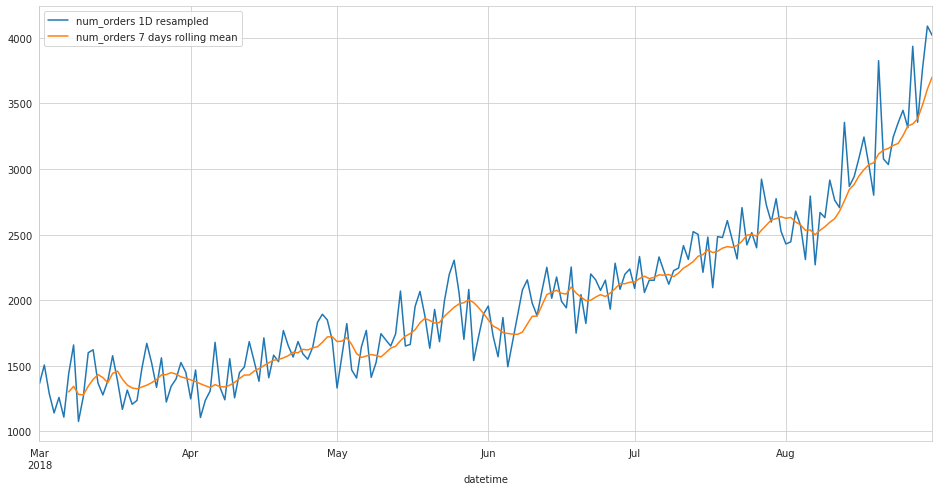

In [14]:
plt.figure(figsize=(16,8))
taxi['num_orders'].resample('1D').sum().plot()
taxi['num_orders'].resample('1D').sum().rolling(7).mean().plot()
plt.legend(['num_orders 1D resampled', 'num_orders 7 days rolling mean'])
plt.show()

- В целом, начиная с апреля заметен постепенный рост количества заказов в день, при этом скорость роста увеличивается и достигает максимума в августе
- Вероятно это связано с тем, что люди часто берут отпуск в летние месяцы, особенно в августе, поэтому количество заказов такси в аэропортах резко увеличивается в эти месяцы

- Рассмотрим отдельно тренды и сезонность данных

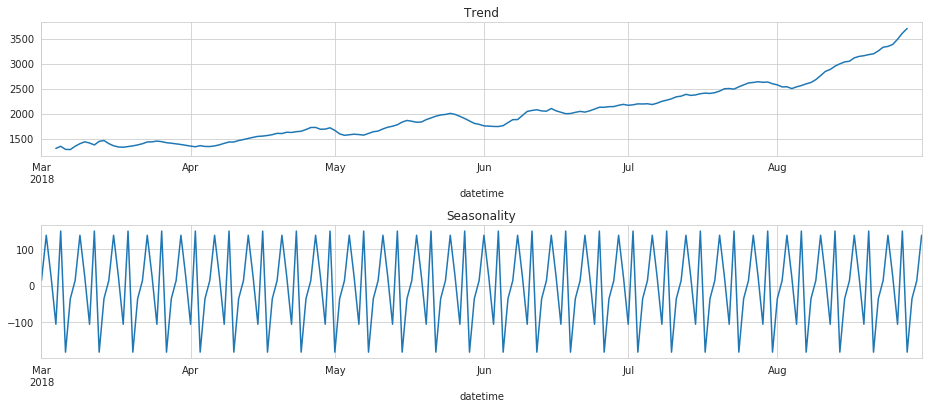

In [15]:
decomposed_high = seasonal_decompose(taxi['num_orders'].resample('1D').sum().dropna())

plt.figure(figsize=(13, 8))
plt.subplot(311)

decomposed_high.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed_high.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

# plt.subplot(313)
# decomposed_high.resid.plot(ax=plt.gca())
# plt.title('Residuals')

plt.tight_layout()

- Тренд увеличения количества заказов в летние месяцы и особенно в августе подтверждается
- Кроме того сезонность показывает, что есть определенные мелкомасштабные зависимости, попробуем их заметить

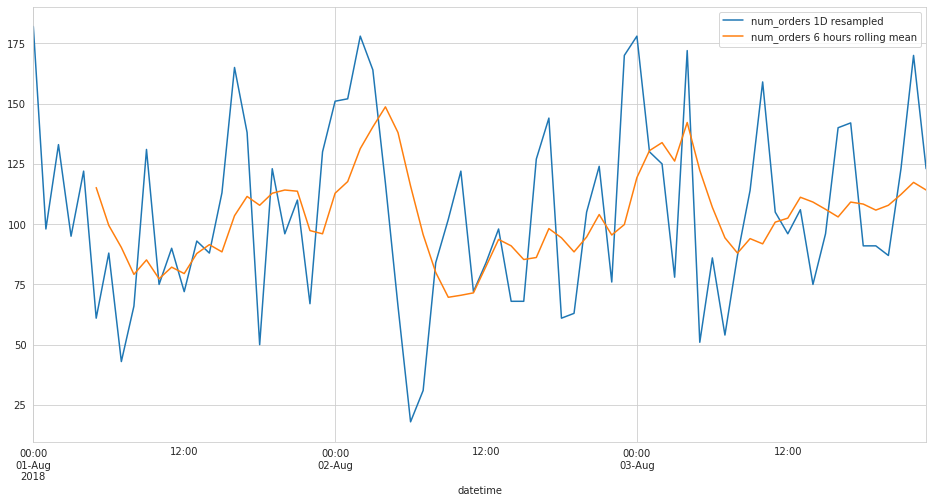

In [16]:
plt.figure(figsize=(16,8))
taxi['2018-08-01':'2018-08-03']['num_orders'].plot()
taxi['2018-08-01':'2018-08-03']['num_orders'].rolling(6).mean().plot()
plt.legend(['num_orders 1D resampled', 'num_orders 6 hours rolling mean'])
plt.show()

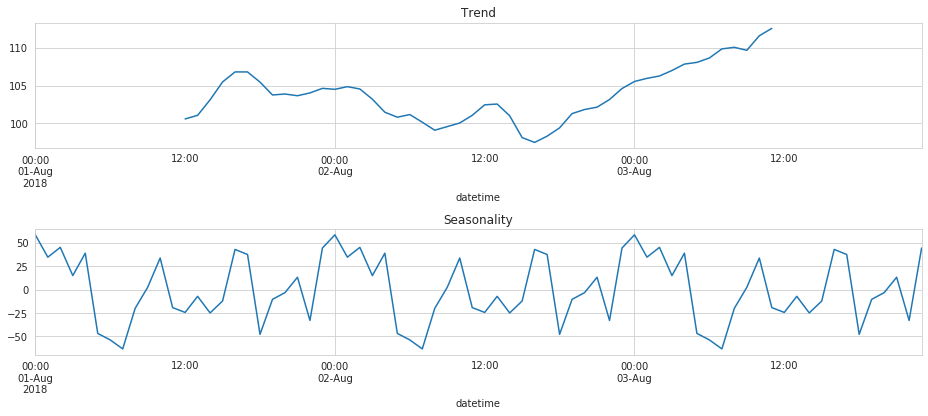

In [17]:
decomposed_low = seasonal_decompose(taxi['2018-08-01':'2018-08-03']['num_orders'].dropna())

plt.figure(figsize=(13, 8))
plt.subplot(311)

decomposed_low.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed_low.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

# plt.subplot(313)
# decomposed_low.resid.plot(ax=plt.gca())
# plt.title('Residuals')

plt.tight_layout()

- Можно заметить, что есть 3 периода времени в течении дня, когда наибольший спрос на такси в аэрпортах: 12:00, 18:00 и 0:00

## Создание новых признаков, разделение на обучающую и тестовую выборки

- Напишем функцию, которая будет создавать новые признаки из временного ряда:
    - календарные (год, месяц, день, день недели)
    - отстающие значения
    - скользящее среднее

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    """
    generates new features from provided time series
    
    params:
    - data - time series pandas dataframe to create new features in
    - max_lag - number of lags to generate
    - rolling_mean_size - size of rolling mean window
    
    returns:
    - copy - original time series pandas dataframe with new generated features
    """
    copy = data.copy(deep=True)
    #copy['day'] = copy.index.day
    copy['dayofweek'] = copy.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        copy['lag_{}'.format(lag)] = copy['num_orders'].shift(lag)

    copy['rolling_mean'] = copy['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return copy

- Также напишем отдельную функцию для разделения данных временного ряда на обучающую и тестовую выборки

In [19]:
def ts_train_test_split(data):
    """
    splits time series into train and test sets, then creates train and test feature and label arrays
    
    params:
    - data - time series pandas dataframe to split
    
    returns:
    - X_train - train feature array
    - X_test - test feature array
    - y_train - train label array
    - y_test - test label array
    """
    train, test = train_test_split(data, shuffle=False, test_size=0.1)
    train = train.dropna()
    
    X_train = train.drop('num_orders', axis=1)
    X_test = test.drop('num_orders', axis=1)
    y_train = train[['num_orders']]
    y_test = test[['num_orders']]
    
    return X_train, X_test, y_train, y_test

## Обучение и тестирование моделей

- Напишем функции для обучения, подбора гиперпараметров модели с помощью RandomizedSearchCV или GridSearchCV и расчет RMSE и R2 по тестовой выборке
- Отдельно напишем функцию для обучения линейной регрессии, т.к. для ее реализации в sklearn нет гиперпараметров. Будем использовать кросс-валидацию для оценки качества модели

In [20]:
def reg_gs_score(model, x_train, y_train, x_test, y_test, cv_k, hp_space, seed=24, scale=False, randomcv=False, n=10):
    """
    scores the regression model using RandomizedSearchCV or GridSearchCV, RMSE and R squared
    
    params:
    - model - regression model
    - x_train - training features
    - y_train - training labels
    - x_test - test features
    - y_test - test labels
    - cv_k - cv parameter for RandomizedSearchCV and GridSearchCV
    - hp_space - hyperparameter space
    - seed=24 - seed
    - scale=False - True if the model needs to be scaled (StandardScaler applied)
    - randomcv=False - True if RandomizedSearchCV is prefered over GridSearchCV
    - n=10 - n_iter parameter for RandomizedSearchCV
    
    returns:
    - rmse_test - RMSE test
    - r2_test - r squared on the test set
    - rmse_val - RMSE validation
    - reg_gs_best_params - model's best parameters from RandomizedSearchCV based on RMSE
    - reg_gs_best_model - best model from RandomizedSearchCV based RMSE
    - y_pred - best model's predictions
    """
    if scale:
        scaler = StandardScaler()
        reg = model
        
        steps = [('scaler', scaler), ('reg', reg)]
        pipeline = Pipeline(steps)
        
        new_hp_space = {}
        for key, val in hp_space.items():
            new_hp_space['reg__'+key] = val
            
        hp_space = new_hp_space.copy()
    else:
        pipeline = model
        
    if randomcv:
        reg_gs = RandomizedSearchCV(pipeline, 
                                    hp_space, 
                                    cv=cv_k, 
                                    scoring='neg_mean_squared_error',
                                    random_state=seed,
                                    #verbose=1,
                                    n_iter=n
                                   )
    else:
        reg_gs = GridSearchCV(pipeline, 
                              hp_space, 
                              cv=cv_k, 
                              scoring='neg_mean_squared_error',
                              #verbose=1
                             )
    
    reg_gs.fit(x_train, y_train)
    
    reg_gs_best_params = reg_gs.best_params_
    reg_gs_best_model = reg_gs.best_estimator_
    rmse_val = np.sqrt(-reg_gs.best_score_).round(3)
    
    if scale:
        reg_gs_best_params_out_of_pipe = {}
        for key, val in reg_gs_best_params.items():
            reg_gs_best_params_out_of_pipe[key[5:]] = val
    else:
        reg_gs_best_params_out_of_pipe = reg_gs_best_params.copy()
    
    y_pred = reg_gs_best_model.predict(x_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred)).round(3)
    r2_test = r2_score(y_test, y_pred).round(3)
    
    return rmse_test, r2_test, rmse_val, reg_gs_best_params, reg_gs_best_params_out_of_pipe, reg_gs_best_model, y_pred

In [21]:
def bm_linreg_cv_score(x_train, y_train, x_test, y_test, cv_k):
    """
    scores sklearn's LinearRegression model using cross_validate on neg_mean_squared_error score function
    
    params:
    - x_train - training features
    - y_train - training labels
    - x_test - test features
    - y_test - test labels
    - cv_k - cv parameter for cross-validation
    
    returns:
    - rmse_test - RMSE test
    - rmse_val - RMSE validation
    - rmse_train - RMSE train
    - y_pred - best model's predictions
    """
    scaler = StandardScaler()
    linreg = LinearRegression()

    steps = [('scaler', scaler), ('linreg', linreg)]
    pipeline = Pipeline(steps)

    train_val_score_linreg_1 = cross_validate(pipeline,
                                              x_train, 
                                              y_train, 
                                              cv=cv_k, 
                                              scoring='neg_mean_squared_error',
                                              return_train_score=True
                                              )
    
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)

    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred)).round(3)
    rmse_val = np.sqrt(-train_val_score_linreg_1['test_score'].mean()).round(3)
    rmse_train = np.sqrt(-train_val_score_linreg_1['train_score'].mean()).round(3)
    
    return rmse_test, rmse_val, rmse_train, y_pred

In [22]:
def ts_feature_params_tuning(data, 
                             max_lag_range, 
                             rolling_mean_size_range,
                             cv_k,
                             model=None,
                             hp_space={}, 
                             seed=24, 
                             scale=False, 
                             randomcv=False, 
                             n=10, 
                             linreg=False
                            ):
    """
    finds the best combination of provided ranges of number of lags, rolling mean window size and model's hyperparameters
    
    params:
    - data - pandas dataframe to tune on
    - max_lag_range - range of number of lag features 
    - rolling_mean_size_range - range of rolling mean window size 
    - cv_k - cv parameter for RandomizedSearchCV and GridSearchCV
    - model=None - regression model
    - hp_space={} - hyperparameter space 
    - seed=24, 
    - scale=False - True if the model needs to be scaled (StandardScaler applied)
    - randomcv=False - True if RandomizedSearchCV is prefered over GridSearchCV
    - n=10 - n_iter parameter for RandomizedSearchCV
    - linreg=False - True if the model is sklearn's LinearRegression
    
    returns: 
    - results - list of the list of the dictionary (best model's hyperparameters), the tuple (the best number of lags and 
    rolling mean window size) and the tuple of predicted values and test data
    """
    results = []
    if linreg:
        for lag, rollmean in product(max_lag_range, rolling_mean_size_range):
            temp = make_features(data, lag, rollmean)
            X_train, X_test, y_train, y_test = ts_train_test_split(temp)
            rmse_test, rmse_val, rmse_train, y_pred = bm_linreg_cv_score(X_train, y_train, X_test, y_test, cv_k)
            y_pred = pd.DataFrame(y_pred, index=y_test.index)
            if len(results) == 0:
                results.append(
                    [
                        {'rmse_test': rmse_test, 
                         'rmse_val': rmse_val, 
                         'rmse_train': rmse_train
                        }, 
                        (lag, rollmean),
                        (y_pred, y_test)
                    ]
                               )
            else:
                if rmse_test < results[0][0]['rmse_test']:
                    results.pop()
                    results.append(
                        [
                            {'rmse_test': rmse_test, 
                             'rmse_val': rmse_val, 
                             'rmse_train': rmse_train
                            }, 
                            (lag, rollmean),
                            (y_pred, y_test)
                        ]
                                   )
    else:
        for lag, rollmean in product(max_lag_range, rolling_mean_size_range):
            temp = make_features(data, lag, rollmean)
            X_train, X_test, y_train, y_test = ts_train_test_split(temp)
            rmse_test, r2_test, rmse_val, best_params, best_params_no_pipe, best_model, y_pred = reg_gs_score(model, 
                                                                                                              X_train, 
                                                                                                              y_train, 
                                                                                                              X_test, 
                                                                                                              y_test, 
                                                                                                              cv_k, 
                                                                                                              hp_space, 
                                                                                                              seed=seed, 
                                                                                                              scale=scale, 
                                                                                                              randomcv=randomcv, 
                                                                                                              n=n
                                                                                                             )
            y_pred = pd.DataFrame(y_pred, index=y_test.index)
            if len(results) == 0:
                results.append(
                    [
                        {'rmse_test': rmse_test, 
                         'r2_test': r2_test, 
                         'rmse_val': rmse_val, 
                         'best_params': best_params, 
                         'best_params_no_pipe': best_params_no_pipe, 
                         'best_model': best_model
                        }, 
                        (lag, rollmean),
                        (y_pred, y_test)
                    ]
                               )
            else:
                if rmse_test < results[0][0]['rmse_test']:
                    results.pop()
                    results.append(
                        [
                            {'rmse_test': rmse_test, 
                             'r2_test': r2_test, 
                             'rmse_val': rmse_val, 
                             'best_params': best_params, 
                             'best_params_no_pipe': best_params_no_pipe, 
                             'best_model': best_model
                            }, 
                            (lag, rollmean),
                            (y_pred, y_test)
                        ]
                                  )
    return results

- Кросс-валидация для временных рядов отличается от других данных, т.к. здесь мы не можем перемешивать данные, и тестовые данные всегда должны быть хронологически позже данных тренировочных
- Создадим объект TimeSeriesSplit и будем использовать его в параметре cv для RandomizedSearchCV, GridSearchCV и cross_validate функций sklearn

In [23]:
time_split = TimeSeriesSplit(n_splits=8)

- Обучим следующие модели:
    - LinearRegression
    - ElasticNet
    - RandomForestRegressor
    - LightGBM Regressor

- Зададим множества значений количества признаков отстающих значений и размера окна скользящего среднего для тюнинга этих параметров совместно с гиперпараметрами выбранных моделей

In [24]:
number_of_lags_range = [5, 50, 100, 150]
rollmean_size_window_range = [3, 5, 7, 9, 15]

### LinearRegression

In [25]:
%%time
linreg_results = ts_feature_params_tuning(taxi, 
                                          number_of_lags_range, 
                                          rollmean_size_window_range, 
                                          time_split, 
                                          linreg=True
                                         )

CPU times: user 31.9 s, sys: 31.6 s, total: 1min 3s
Wall time: 1min 3s


In [26]:
print('best number of lags: {}'.format(linreg_results[0][1][0]))
print('best rolling mean window size: {}'.format(linreg_results[0][1][1]))
print('RMSE test: {}'.format(linreg_results[0][0]['rmse_test']))
print('RMSE valid: {}'.format(linreg_results[0][0]['rmse_val']))
print('RMSE train: {}'.format(linreg_results[0][0]['rmse_train']))

best number of lags: 150
best rolling mean window size: 5
RMSE test: 38.894
RMSE valid: 24.157
RMSE train: 18.011


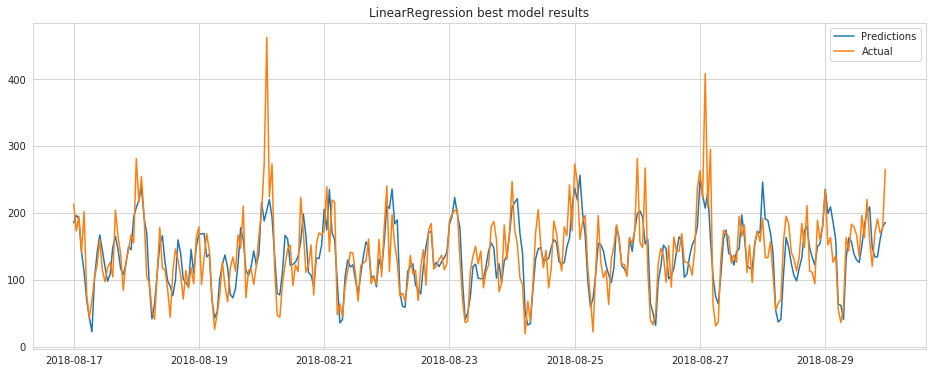

In [27]:
plt.figure(figsize=(16,6))
plt.plot(linreg_results[0][2][0]['2018-08-17':'2018-08-29'].resample('1H').sum())
plt.plot(linreg_results[0][2][1]['2018-08-17':'2018-08-29'].resample('1H').sum())
plt.title('LinearRegression best model results')
plt.legend(['Predictions', 'Actual'])
plt.show()

- Видно, что часть цикличных пиков модель не может подцепить, посмотрим один из таких детальнее

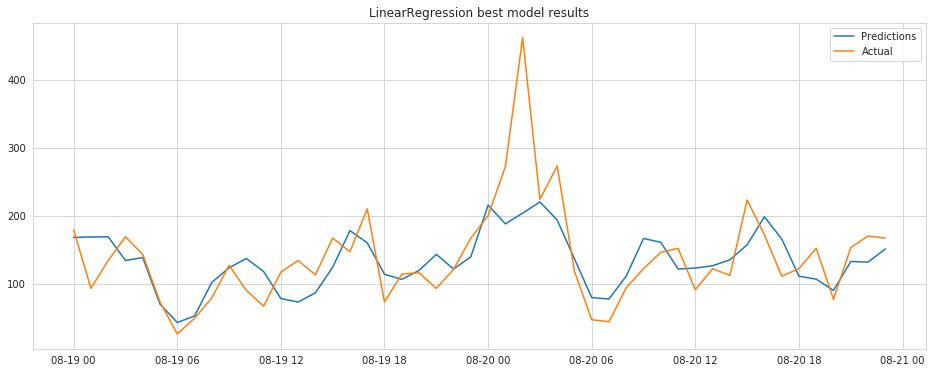

In [28]:
plt.figure(figsize=(16,6))
plt.plot(linreg_results[0][2][0]['2018-08-19':'2018-08-20'].resample('1H').sum())
plt.plot(linreg_results[0][2][1]['2018-08-19':'2018-08-20'].resample('1H').sum())
plt.title('LinearRegression best model results')
plt.legend(['Predictions', 'Actual'])
plt.show()

In [59]:
linreg_results[0][2][1]['2018-08-20'].resample('1D').sum().index.day_name()

Index(['Monday'], dtype='object', name='datetime')

- Модель слишком сильно усредняет пиковые значения после полуночи, которые возникают судя по предыдущему графику один раз в неделю после полуночи по понедельникам

### ElasticNet

In [29]:
%%time
hs_en = {'alpha': np.linspace(0.01, 0.1, 9),
         'l1_ratio': np.linspace(0, 1, 10)
        }
en_results = ts_feature_params_tuning(taxi, 
                                      number_of_lags_range, 
                                      rollmean_size_window_range,
                                      time_split,
                                      model=ElasticNet(random_state=24),
                                      hp_space=hs_en, 
                                      seed=24, 
                                      scale=True, 
                                      randomcv=True, 
                                      n=5, 
                                      linreg=False
                                     )

CPU times: user 5min 57s, sys: 6min 47s, total: 12min 45s
Wall time: 12min 45s


In [30]:
print('best number of lags: {}'.format(en_results[0][1][0]))
print('best rolling mean window size: {}'.format(en_results[0][1][1]))
print('ElasticNet best params: {}'.format(en_results[0][0]['best_params']))
print('RMSE test: {}'.format(en_results[0][0]['rmse_test']))
print('RMSE valid: {}'.format(en_results[0][0]['rmse_val']))
print('R2 test: {}'.format(en_results[0][0]['r2_test']))

best number of lags: 150
best rolling mean window size: 3
ElasticNet best params: {'reg__l1_ratio': 0.5555555555555556, 'reg__alpha': 0.1}
RMSE test: 38.995
RMSE valid: 23.679
R2 test: 0.556


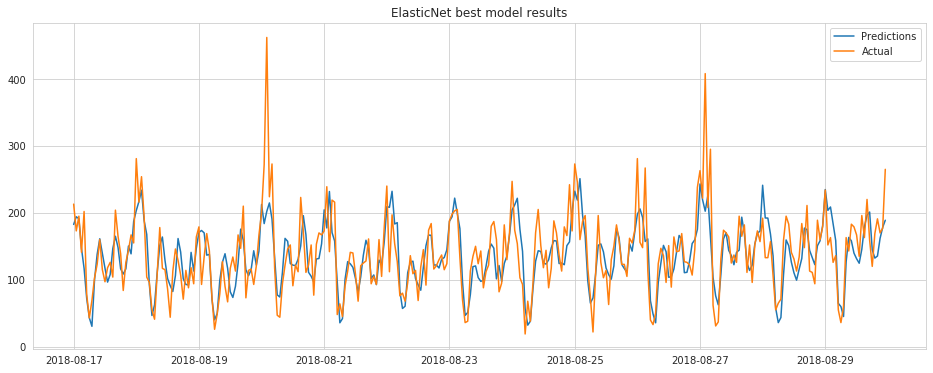

In [31]:
plt.figure(figsize=(16,6))
plt.plot(en_results[0][2][0]['2018-08-17':'2018-08-29'].resample('1H').sum())
plt.plot(en_results[0][2][1]['2018-08-17':'2018-08-29'].resample('1H').sum())
plt.title('ElasticNet best model results')
plt.legend(['Predictions', 'Actual'])
plt.show()

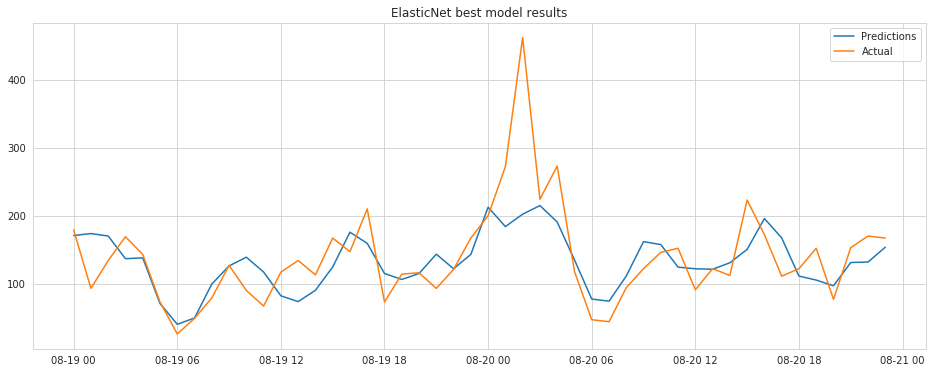

In [32]:
plt.figure(figsize=(16,6))
plt.plot(en_results[0][2][0]['2018-08-19':'2018-08-20'].resample('1H').sum())
plt.plot(en_results[0][2][1]['2018-08-19':'2018-08-20'].resample('1H').sum())
plt.title('ElasticNet best model results')
plt.legend(['Predictions', 'Actual'])
plt.show()

- ElasticNet сработала практически также, как и LinearRegression: не удалось подцепить пиковые значения заказов, которые циклично возникают в августе после полуночи по понедельникам

### RandomForestRegressor

In [39]:
%%time
hs_rf = {'max_depth': np.arange(5, 12),
         'max_features': np.arange(3, 8),
         #'n_estimators': [100, 200, 400]
        }
rf_results = ts_feature_params_tuning(taxi, 
                                      number_of_lags_range, 
                                      rollmean_size_window_range,
                                      time_split,
                                      model=RandomForestRegressor(random_state=24,
                                                                  n_jobs=-1
                                                                 ),
                                      hp_space=hs_rf, 
                                      seed=24, 
                                      scale=False, 
                                      #randomcv=True, 
                                      n=5, 
                                      linreg=False
                                     )

CPU times: user 5min 55s, sys: 0 ns, total: 5min 55s
Wall time: 5min 59s


In [40]:
print('best number of lags: {}'.format(rf_results[0][1][0]))
print('best rolling mean window size: {}'.format(rf_results[0][1][1]))
print('RandomForest best params: {}'.format(rf_results[0][0]['best_params']))
print('RMSE test: {}'.format(rf_results[0][0]['rmse_test']))
print('RMSE valid: {}'.format(rf_results[0][0]['rmse_val']))
print('R2 test: {}'.format(rf_results[0][0]['r2_test']))

best number of lags: 100
best rolling mean window size: 15
RandomForest best params: {'max_depth': 10, 'max_features': 7}
RMSE test: 42.228
RMSE valid: 25.558
R2 test: 0.48


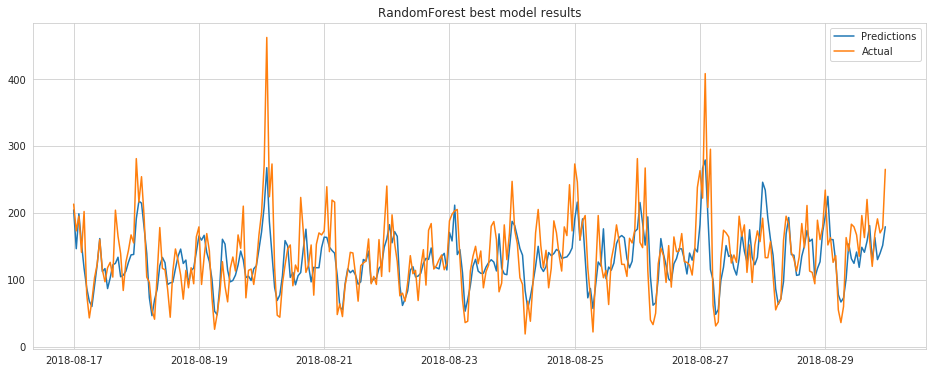

In [41]:
plt.figure(figsize=(16,6))
plt.plot(rf_results[0][2][0]['2018-08-17':'2018-08-29'].resample('1H').sum())
plt.plot(rf_results[0][2][1]['2018-08-17':'2018-08-29'].resample('1H').sum())
plt.title('RandomForest best model results')
plt.legend(['Predictions', 'Actual'])
plt.show()

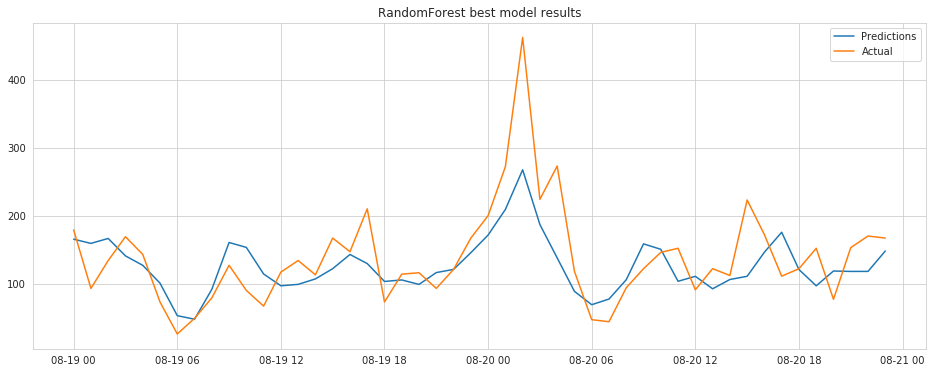

In [42]:
plt.figure(figsize=(16,6))
plt.plot(rf_results[0][2][0]['2018-08-19':'2018-08-20'].resample('1H').sum())
plt.plot(rf_results[0][2][1]['2018-08-19':'2018-08-20'].resample('1H').sum())
plt.title('RandomForest best model results')
plt.legend(['Predictions', 'Actual'])
plt.show()

- RandomForest чуть лучше сработал на пиковых значениях полуночи по понедельникам, но в целом, как мы видим по величине ошибки, хуже сработал на других значениях временного ряда

### LightGBM Regressor

In [43]:
%%time
hs_lgb = {'num_iterations': [100, 200],
         'max_depth': [5, 7]
         }
lgb_results = ts_feature_params_tuning(taxi, 
                                       number_of_lags_range, 
                                       rollmean_size_window_range,
                                       time_split,
                                       model=lgb.LGBMRegressor(),
                                       hp_space=hs_lgb, 
                                       seed=24, 
                                       scale=False, 
                                       randomcv=False, 
                                       n=10, 
                                       linreg=False
                                      )

CPU times: user 41min 14s, sys: 0 ns, total: 41min 14s
Wall time: 41min 44s


In [44]:
print('best number of lags: {}'.format(lgb_results[0][1][0]))
print('best rolling mean window size: {}'.format(lgb_results[0][1][1]))
print('LightGBMRegressor best params: {}'.format(lgb_results[0][0]['best_params']))
print('RMSE test: {}'.format(lgb_results[0][0]['rmse_test']))
print('RMSE valid: {}'.format(lgb_results[0][0]['rmse_val']))
print('R2 test: {}'.format(lgb_results[0][0]['r2_test']))

best number of lags: 150
best rolling mean window size: 5
LightGBMRegressor best params: {'max_depth': 7, 'num_iterations': 100}
RMSE test: 38.142
RMSE valid: 23.72
R2 test: 0.576


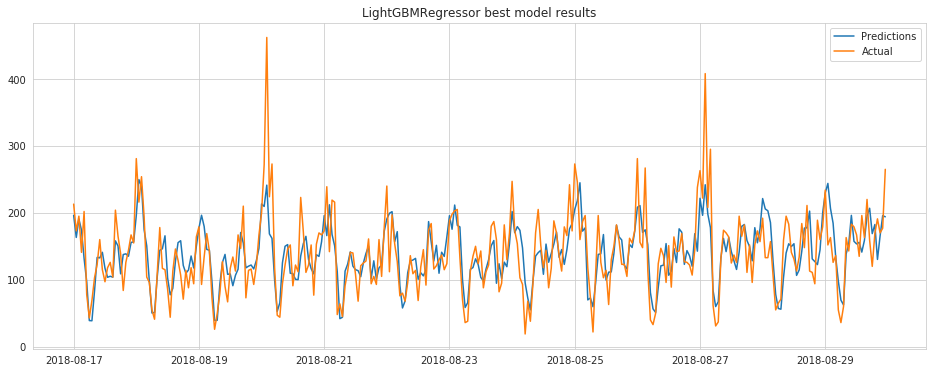

In [45]:
plt.figure(figsize=(16,6))
plt.plot(lgb_results[0][2][0]['2018-08-17':'2018-08-29'].resample('1H').sum())
plt.plot(lgb_results[0][2][1]['2018-08-17':'2018-08-29'].resample('1H').sum())
plt.title('LightGBMRegressor best model results')
plt.legend(['Predictions', 'Actual'])
plt.show()

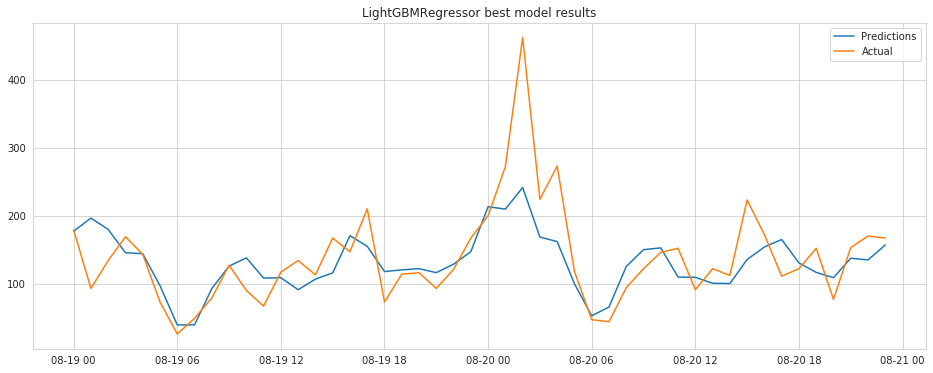

In [46]:
plt.figure(figsize=(16,6))
plt.plot(lgb_results[0][2][0]['2018-08-19':'2018-08-20'].resample('1H').sum())
plt.plot(lgb_results[0][2][1]['2018-08-19':'2018-08-20'].resample('1H').sum())
plt.title('LightGBMRegressor best model results')
plt.legend(['Predictions', 'Actual'])
plt.show()

- LightGBMRegressor в целом смог довольно неплохо подцепить дневную сезонность данных, но по-прежнему есть проблема с прогнозированием пиковых понедельничных значений после полуночи

## Анализ моделей

In [47]:
model_results = pd.DataFrame({'rmse_test' : [linreg_results[0][0]['rmse_test'], 
                                             en_results[0][0]['rmse_test'], 
                                             rf_results[0][0]['rmse_test'], 
                                             lgb_results[0][0]['rmse_test'], 
                                            ], 
                              'rmse_val': [linreg_results[0][0]['rmse_val'], 
                                           en_results[0][0]['rmse_val'], 
                                           rf_results[0][0]['rmse_val'], 
                                           lgb_results[0][0]['rmse_val'], 
                                          ],
                             },
                             index=['LinearRegression', 
                                    'ElasticNet', 
                                    'RandomForestRegressor', 
                                    'LightGBMRegressor', 
                                   ]
                            )
model_results.sort_values(by='rmse_test')

,rmse_test,rmse_val
LightGBMRegressor,38.142,23.720
LinearRegression,38.894,24.157
ElasticNet,38.995,23.679
RandomForestRegressor,42.228,25.558


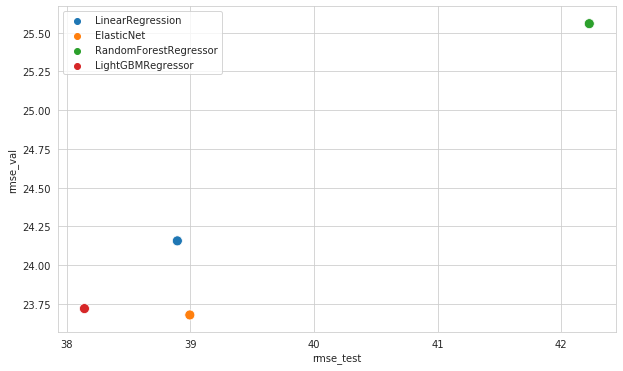

In [48]:
plt.figure(figsize=(10,6))
sns.scatterplot(model_results['rmse_test'], 
                model_results['rmse_val'], 
                hue=model_results.index,
                s=100
               )
plt.legend(loc=2)
plt.show()

**Вывод**

- Все модели показали результат лучше требуемого заказчиком
- Лучший результат показала модель LightGBM Regressor